In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.stats import norm
from scipy.optimize import brentq, minimize, differential_evolution
from scipy.interpolate import interp1d, PchipInterpolator
from numpy.fft import rfft, irfft
import heapq

In [2]:
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 12
})

In [3]:
# ==============================================================================
# UTILITY FUNCTIONS (BSM, IV Solver, Rates)
# ==============================================================================

def bsm_price(S, K, T, r, q, sigma, flag):
    """
    Calculates the Black-Scholes-Merton option price.
    """
    # Handle edge cases T=0 or sigma=0
    if T <= 1e-6 or sigma <= 1e-6:
        if flag == 'c':
            return np.maximum(0, S * np.exp(-q * T) - K * np.exp(-r * T))
        else:
            return np.maximum(0, K * np.exp(-r * T) - S * np.exp(-q * T))
    
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if flag == 'c':
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

def find_implied_vol(target_price, S, K, T, r, q, flag):
    """
    Numerically solves for the implied volatility using Brent's method.
    """
    # Basic check for arbitrage bounds (price must be >= intrinsic value)
    intrinsic_value = bsm_price(S, K, T, r, q, 1e-6, flag)
    if target_price < intrinsic_value:
        # If the MC price is slightly below intrinsic due to noise, we might clip it, 
        # but often it's better to return NaN to signal an issue in the cost function.
        return np.nan

    objective = lambda sigma: bsm_price(S, K, T, r, q, sigma, flag) - target_price
    try:
        return brentq(objective, 1e-6, 5.0, xtol=1e-6, rtol=1e-6, maxiter=100)
    except (ValueError, RuntimeError):
        return np.nan

def get_risk_free_rate_data():
    """Provides US Treasury data (Example Data)."""
    # In a real scenario, this would fetch live data or read from a dynamic file.
    treasury_data = {
        'Maturity_str': ['1-Month', '3-Months', '6-Months', '1-Year', '2-Years', '5-Years', '7-Years', '10-Years', '20-Years', '30-Years'],
        'Rate_str': ['4.37 %', '4.42 %', '4.31 %', '4.09 %', '3.91 %', '3.95 %', '4.15 %', '4.40 %', '4.92 %', '4.92 %']
    }
    return pd.DataFrame(treasury_data)

def create_risk_free_rate_interpolator(treasury_df):
    """Creates a continuous risk-free rate function (r_func)."""
    maturity_map = {
        '1-Month': 1/12, '3-Months': 3/12, '6-Months': 6/12, '1-Year': 1.0,
        '2-Years': 2.0, '5-Years': 5.0, '7-Years': 7.0, '10-Years': 10.0,
        '20-Years': 20.0, '30-Years': 30.0
    }
    treasury_df = treasury_df.copy()
    treasury_df['T'] = treasury_df['Maturity_str'].map(maturity_map)
    treasury_df['Rate'] = treasury_df['Rate_str'].str.replace(' %', '', regex=False).astype(float) / 100
    # Linear interpolation with flat extrapolation is generally robust
    return interp1d(treasury_df['T'].values, treasury_df['Rate'].values, kind='linear', fill_value="extrapolate")

# ==============================================================================
# FORWARD VARIANCE BOOTSTRAPPING FUNCTIONS
# ==============================================================================

def extract_atm_volatility_curve(surface_df, S0):
    """
    Extracts the At-the-Money (ATM Forward) volatility curve.
    """
    print("\n--- Extracting ATM Volatility Curve from Market Data ---")
    df = surface_df.copy()
    
    # Calculate Forward Price F = S0 * exp((r-q)*T)
    df['forward_price'] = S0 * np.exp((df['risk_free_rate'] - df['dividend_yield']) * df['time_to_maturity'])
    
    # Calculate distance from ATM Forward
    df['atm_distance'] = np.abs(df['strike'] - df['forward_price'])
    
    # Select the option closest to the forward price for each maturity
    atm_indices = df.groupby('time_to_maturity')['atm_distance'].idxmin()
    
    atm_curve = df.loc[atm_indices]
    
    atm_curve_formatted = atm_curve[['time_to_maturity', 'implied_vol']].rename(
        columns={'time_to_maturity': 'T', 'implied_vol': 'market_iv'}
    ).sort_values('T')
    
    print(f"Extracted {len(atm_curve_formatted)} ATM points.")
    return atm_curve_formatted

def create_xi_from_market_atm(market_atm_curve_df):
    """
    Bootstraps the forward variance curve (xi_func) from ATM implied volatilities.
    """
    print("\n--- Creating market-consistent xi_func from ATM Volatilities ---")
    
    df = market_atm_curve_df.sort_values('T').copy()

    # Ensure T=0 exists
    if not df.empty and not np.isclose(df['T'].iloc[0], 0.0):
        initial_point = pd.DataFrame({'T': [0.0], 'market_iv': [df['market_iv'].iloc[0]]})
        df = pd.concat([initial_point, df]).reset_index(drop=True)
    
    # 1. Total Variance (W = IV^2 * T)
    df['total_variance'] = df['T'] * (df['market_iv']**2)
    
    # 2. Forward Variance (xi = dW/dT) using discrete differences
    df['forward_variance'] = (df['total_variance'].diff()) / (df['T'].diff())
    
    # 3. Fill T=0 (Instantaneous variance)
    if not df.empty:
       df.iat[0, df.columns.get_loc('forward_variance')] = df['market_iv'].iat[0]**2
    
    # 4. Ensure non-negative forward variances (Arbitrage constraint)
    df['forward_variance'] = df['forward_variance'].clip(lower=1e-6)
    
    # 5. Create interpolation function (xi_func) with flat extrapolation
    new_xi_func = interp1d(
        df['T'].values,
        df['forward_variance'].values,
        kind='linear', # Linear is often more stable than cubic for bootstrapped data
        bounds_error=False,
        fill_value=(df['forward_variance'].iloc[0], df['forward_variance'].iloc[-1])
    )

    print("Market-consistent xi_func created successfully.")
    return new_xi_func

# ==============================================================================
# DATA PREPARATION AND GRID SELECTION
# ==============================================================================

def prepare_full_surface_and_rates(file_path, constant_dividend_yield=0.02):
    """
    Reads, cleans, and processes the raw options data file.
    """
    print("--- Reading and processing raw options data... ---")
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None, None, None, None, None
        
    df.columns = [col.strip().lower() for col in df.columns]
    
    # Filter for liquid options with valid prices
    df_filtered = df[(df['bid_eod'] > 0) & (df['ask_eod'] > 0) & (df['trade_volume'] > 10)].copy()
    
    if df_filtered.empty:
        print("Error: No valid options found after initial filtering.")
        return None, None, None, None, None

    # Time to Maturity Calculation
    df_filtered['quote_date'] = pd.to_datetime(df_filtered['quote_date'])
    df_filtered['expiration'] = pd.to_datetime(df_filtered['expiration'])
    df_filtered['time_to_maturity'] = (df_filtered['expiration'] - df_filtered['quote_date']).dt.days / 365.0
    # Exclude very short maturities
    df_filtered = df_filtered[df_filtered['time_to_maturity'] > (7 / 365.0)].reset_index(drop=True)
    
    if df_filtered.empty:
        print("Error: No options found after maturity filtering.")
        return None, None, None, None, None

    # Determine Spot and Date
    spot_price = (df_filtered['underlying_bid_eod'].iloc[0] + df_filtered['underlying_ask_eod'].iloc[0]) / 2
    quote_date = df_filtered['quote_date'].iloc[0]
    
    # Rates (r_func and q_func)
    treasury_df = get_risk_free_rate_data()
    r_func = create_risk_free_rate_interpolator(treasury_df)
    q_val = constant_dividend_yield
    q_func = lambda T: q_val
    
    df_filtered['risk_free_rate'] = df_filtered['time_to_maturity'].apply(r_func)
    df_filtered['dividend_yield'] = q_val
    df_filtered['mid_price'] = (df_filtered['bid_eod'] + df_filtered['ask_eod']) / 2
    
    # Calculate Market Implied Volatility
    df_filtered['implied_vol'] = df_filtered.apply(
        lambda row: find_implied_vol(row['mid_price'], spot_price, row['strike'], row['time_to_maturity'], row['risk_free_rate'], row['dividend_yield'], row['option_type'].lower()),
        axis=1
    )
    
    final_surface_df = df_filtered.dropna(subset=['implied_vol']).copy()
    
    print(f"Data processing complete. Found {len(final_surface_df)} valid options. S0={spot_price:.2f}")
    return spot_price, quote_date, final_surface_df, r_func, q_func

def create_calibration_grid(full_surface_df, spot_price, num_options=50):
    """
    Selects a representative subset of options for calibration and displays the summary.
    """
    print(f"\n--- Selecting approx. {num_options} representative options for calibration... ---")
    
    # Calculate moneyness (K/S)
    if 'moneyness' not in full_surface_df.columns:
        # Use .loc to ensure we modify the DataFrame correctly
       full_surface_df.loc[:, 'moneyness'] = full_surface_df['strike'] / spot_price
    
    # Define target grid
    target_maturities_years = np.array([1/12, 3/12, 6/12, 1, 2, 5])
    target_moneyness_levels = np.array([0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25])

    grid_points = pd.DataFrame([{'T': t, 'M': m} for t in target_maturities_years for m in target_moneyness_levels])

    # Find closest options
    selected_indices = set()
    for _, point in grid_points.iterrows():
        if full_surface_df.empty:
            continue
        # Calculate Euclidean distance in (T, M) space
        distances = np.sqrt(
            (full_surface_df['time_to_maturity'] - point['T'])**2 +
            (full_surface_df['moneyness'] - point['M'])**2
        )
        # Ensure distances are valid before finding minimum
        if not distances.empty and not distances.isnull().all():
            closest_idx = distances.idxmin()
            selected_indices.add(closest_idx)

    if not selected_indices:
        print("Warning: Could not select any options for the calibration grid.")
        return pd.DataFrame()

    calibration_df = full_surface_df.loc[list(selected_indices)].reset_index(drop=True)
    
    # Display Summary
    print("\n--- Summary of Options Selected for Calibration ---")
    display_cols = [
        'expiration', 'strike', 'option_type', 'time_to_maturity',
        'moneyness', 'implied_vol'
    ]
    display_df = calibration_df[display_cols].copy()

    # Formatting
    display_df['expiration'] = display_df['expiration'].dt.strftime('%Y-%m-%d')
    display_df['T (Years)'] = display_df['time_to_maturity'].round(4)
    display_df['Moneyness'] = display_df['moneyness'].round(3)
    display_df['Market IV (%)'] = (display_df['implied_vol'] * 100).round(2)

    final_display_cols = ['expiration', 'T (Years)', 'strike', 'option_type', 'Moneyness', 'Market IV (%)']

    # Display full table
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
        print(display_df[final_display_cols].sort_values(by=['T (Years)', 'strike']).reset_index(drop=True))

    print(f"\nSelection complete. {len(calibration_df)} unique options selected.")
    return calibration_df

# ==============================================================================
# ROUGH BERGOMI MODEL (Hybrid Scheme Implementation)
# ==============================================================================

class rBergomi:
    """
    A fully vectorized rBergomi simulation engine using the Hybrid Scheme.
    """
    def __init__(self, n_steps, T, H):
        # Initialization (H, T, time grid, dt)
        self.T = float(T)
        self.H = float(H)
        self.alpha = self.H - 0.5
        self.n_steps = int(n_steps)
        self.dt = self.T / self.n_steps if self.n_steps > 0 else 0
        self.time_grid = np.linspace(0, T, self.n_steps + 1)
        
        # Pre-compute covariance matrix for the Hybrid Scheme (W1, W2)
        var_W1 = self.dt
        var_W2 = (self.dt**(2 * self.H)) / (2 * self.H) if self.H > 0 else 0
        cov_W1_W2 = (self.dt**(self.H + 0.5)) / (self.H + 0.5) if self.H > -0.5 else 0
        self.cov_matrix = np.array([[var_W1, cov_W1_W2], [cov_W1_W2, var_W2]])

        # Pre-compute gamma_k coefficients for convolution
        if self.n_steps > 1:
            k = np.arange(2, self.n_steps + 1)
            if np.abs(self.alpha) > 1e-9:
                base = (k**(self.alpha + 1) - (k - 1)**(self.alpha + 1)) / (self.alpha + 1)
                # Ensure numerical stability for negative alpha
                b_k = np.sign(base) * np.abs(base)**(1 / self.alpha)
                self.gamma_k = (b_k * self.dt)**self.alpha
            else: # H=0.5 case (Standard Brownian Motion)
                self.gamma_k = np.zeros_like(k, dtype=float)
        else:
            self.gamma_k = np.array([])

    def generate_paths(self, N_paths, rho, eta, xi_func, S0, r_func, q_func, seed=None):
        """Generates asset price paths."""
        
        # Allow setting a seed for reproducibility (important for SLSQP)
        if seed is not None:
            np.random.seed(seed)

        if self.n_steps == 0:
            return np.full((N_paths, 1), S0)

        # Basic check for positive semi-definiteness (numerical stability)
        # If the matrix is near singular, regularization might be needed.
        if np.linalg.cond(self.cov_matrix) > 1/np.finfo(self.cov_matrix.dtype).eps:
             # Handle near-singular matrix by slightly adjusting correlation if needed
             corr = self.cov_matrix[0,1] / np.sqrt(self.cov_matrix[0,0] * self.cov_matrix[1,1])
             if abs(corr) > 1.0:
                clipped_corr = np.clip(corr, -1.0, 1.0)
                self.cov_matrix[0,1] = self.cov_matrix[1,0] = clipped_corr * np.sqrt(self.cov_matrix[0,0] * self.cov_matrix[1,1])

        # Generate correlated Brownian increments (W1, W2)
        try:
            dW_vectors = np.random.multivariate_normal([0, 0], self.cov_matrix, size=(N_paths, self.n_steps))
        except (np.linalg.LinAlgError, ValueError) as e:
            print(f"Warning: Covariance matrix issue during path generation (H={self.H}): {e}")
            return None

        W1_increments = dW_vectors[:, :, 0]
        W2_increments = dW_vectors[:, :, 1]
        
        # Generate orthogonal component (W_perp)
        dW_perp = np.random.randn(N_paths, self.n_steps) * np.sqrt(self.dt)

        # Simulate the Riemann-Liouville process Y using FFT convolution
        Y = np.zeros((N_paths, self.n_steps + 1))
        if np.any(self.gamma_k) and np.abs(self.alpha) > 1e-9:
            # FFT setup
            gamma_k_padded = np.zeros(self.n_steps)
            if len(self.gamma_k) > 0:
               gamma_k_padded[1:] = self.gamma_k
            fft_len = 2 * self.n_steps
            
            # Convolution via FFT
            gamma_k_fft = rfft(gamma_k_padded, fft_len)
            W1_fft = rfft(W1_increments, fft_len, axis=1)
            
            convolution_sum = irfft(gamma_k_fft * W1_fft, fft_len, axis=1)[:, :self.n_steps]
            Y[:, 1:] = np.sqrt(2 * self.H) * (W2_increments + convolution_sum)
        else: # H=0.5 case
            Y[:, 1:] = np.sqrt(2 * self.H) * W2_increments
        
        # Forward variance curve evaluation
        forward_variances = xi_func(self.time_grid)
        
        # Variance process V(t) (Wick exponential)
        exponent_term = eta * Y - 0.5 * eta**2 * self.time_grid**(2 * self.H)
        # Clip exponent to prevent numerical overflow/underflow
        exponent_term_clipped = np.clip(exponent_term, -30, 30) 
        V = forward_variances * np.exp(exponent_term_clipped)
        
        # Asset price process S(t) using Log-Euler scheme
        S = np.zeros((N_paths, self.n_steps + 1))
        S[:, 0] = S0
        # Ensure variance is strictly positive
        V_sliced = np.maximum(V[:, :-1], 1e-12)
        
        # Time-dependent rates
        time_grid_sliced = self.time_grid[:-1]
        r_t = r_func(time_grid_sliced)
        q_t = q_func(time_grid_sliced)
        
        # Construct correlated asset Brownian motion (dB)
        dB = rho * W1_increments + np.sqrt(1 - rho**2) * dW_perp
        
        # Accumulate log-returns
        log_increments = (r_t - q_t - 0.5 * V_sliced) * self.dt + np.sqrt(V_sliced) * dB
        log_S_paths = np.log(S0) + np.cumsum(log_increments, axis=1)
        
        S[:, 1:] = np.exp(log_S_paths)
        
        return S

# ==============================================================================
# CALIBRATION ENGINE (Enhanced with Top N Tracking and Dual Methods)
# ==============================================================================

class rBergomi_Calibrator:
    def __init__(self, calibration_df, S0, r_func, q_func, xi_func):
        self.S0 = S0
        self.market_df = calibration_df
        self.r_func, self.q_func, self.xi_func = r_func, q_func, xi_func
        
        self.market_data_dict = {
            (row['strike'], row['time_to_maturity']): row['implied_vol']
            for _, row in self.market_df.iterrows()
        }
        self.options_grid = list(self.market_data_dict.keys())
        self.num_options = len(self.options_grid)
        print(f"\nCalibrator initialized with {self.num_options} options.")
        
        # Default settings
        self.n_paths = 50000
        self.n_steps_per_year = 100
        self.use_static_seed = False # Controls seeding in path generation

        # NEW: Tracking mechanism initialization
        self.top_results = []
        self.iteration_count = 0

    def _reset_tracking(self):
        # Reset tracking before a new calibration run
        self.top_results = []
        self.iteration_count = 0

    def _update_top_results(self, mse, params):
        # Update the list of top 10 results
        # We append the result and then sort/truncate. Since the cost function 
        # is expensive, the overhead of sorting this small list is negligible.
        self.top_results.append((mse, params))
        self.top_results.sort(key=lambda x: x[0]) # Sort by MSE (ascending)
        if len(self.top_results) > 10:
            self.top_results = self.top_results[:10] # Keep only top 10

    def _price_options_grid(self, H, rho, eta):
        """
        Prices the calibration grid options using Monte Carlo.
        """
        if not self.options_grid:
            return None
            
        max_maturity = max(maturity for _, maturity in self.options_grid)
        n_steps = int(self.n_steps_per_year * max_maturity)
        if n_steps == 0:
            return None

        model = rBergomi(n_steps=n_steps, T=max_maturity, H=H)
        
        # Determine seed: Static for SLSQP, Dynamic (None) for DE
        seed = 42 if self.use_static_seed else None

        # Generate paths (Note: Batching is omitted here for brevity, assuming memory is sufficient for n_paths)
        S_paths = model.generate_paths(self.n_paths, rho, eta, self.xi_func, self.S0, self.r_func, self.q_func, seed=seed)

        if S_paths is None:
            return None

        # Calculate prices and IVs for the grid
        model_implied_vols = {}
        for option_key in self.options_grid:
            strike, maturity = option_key
            r_option = self.r_func(maturity)
            q_option = self.q_func(maturity)
            
            # Find the correct time index for maturity
            time_idx = int(round(n_steps * (maturity / max_maturity)))
            if time_idx >= S_paths.shape[1]:
                time_idx = S_paths.shape[1] - 1
            
            if time_idx < 0: continue

            S_T = S_paths[:, time_idx]
            
            # Determine option type based on forward
            forward_price = self.S0 * np.exp((r_option - q_option) * maturity)
            option_type = 'c' if strike >= forward_price else 'p'
            
            # Calculate payoff
            if option_type == 'c':
                payoffs = np.maximum(S_T - strike, 0)
            else:
                payoffs = np.maximum(strike - S_T, 0)
            
            # Discounted price
            discounted_price = np.mean(payoffs) * np.exp(-r_option * maturity)
            
            # Back out IV
            iv = find_implied_vol(discounted_price, self.S0, strike, maturity, r_option, q_option, flag=option_type)
            model_implied_vols[option_key] = iv
            
        return model_implied_vols

    def cost_function(self, params):
        """
        The objective function (MSE). Tracks top 10 results during the run.
        """
        self.iteration_count += 1
        H, rho, eta = params
        
        # Safety constraints (though optimizers usually handle bounds)
        if H <= 0.001 or H >= 0.999 or eta <= 0.01 or rho <= -0.999 or rho >= 0.999:
             return 1e10

        # Print progress
        print(f"Iter: {self.iteration_count:04d} | Testing: H={H:.4f}, rho={rho:.4f}, eta={eta:.4f}...", end="")

        model_vols = self._price_options_grid(H, rho, eta)
        if model_vols is None:
            print(" -> MSE: Error (Pricing Failed)")
            return 1e10

        total_squared_error = 0.0
        valid_options = 0
        for option, market_iv in self.market_data_dict.items():
            model_iv = model_vols.get(option, np.nan)
            
            if np.isnan(model_iv) or np.isnan(market_iv):
                # Apply a penalty for failures (e.g., if MC price violates arbitrage bounds)
                total_squared_error += 0.5**2 # Penalty equivalent to 50 vol points error
            else:
                total_squared_error += (model_iv - market_iv)**2
                valid_options += 1
        
        if valid_options == 0:
             print(" -> MSE: Error (No valid options priced)")
             return 1e10

        # Calculate Mean Squared Error (MSE)
        mse = total_squared_error / self.num_options
        
        # NEW: Update top results tracking
        self._update_top_results(mse, {'H': H, 'rho': rho, 'eta': eta})
                
        print(f" -> MSE: {mse:.8f}")
        return mse

    def calibrate_slsqp(self, x0, bounds=None):
        """
        Starts the calibration process using the SLSQP (Local Optimizer).
        """
        self._reset_tracking()
        # SLSQP needs a static seed for stable finite difference gradient estimation
        self.use_static_seed = True

        if bounds is None:
            bounds = [(0.01, 0.49), (-0.99, -0.01), (0.5, 5.5)]
            
        print("\n--- Starting Local Calibration (SLSQP) ---")
        print(f"Settings: N_Paths={self.n_paths}, Steps/Year={self.n_steps_per_year}, Static Seed=True")
        start_time = time.time()
        
        # Call SLSQP. 'eps' is increased to help navigate the noisy MC surface.
        result = minimize(
            self.cost_function,
            x0=x0,
            method='SLSQP',
            bounds=bounds,
            options={'disp': False, 'ftol': 1e-6, 'maxiter': 100, 'eps': 1e-4}
        )
        
        print(f"\n--- SLSQP Calibration finished in {(time.time() - start_time)/60:.2f} minutes ---")
        if result.success:
            print("Optimal parameters found:")
            print(f"H = {result.x[0]:.4f}, rho = {result.x[1]:.4f}, eta = {result.x[2]:.4f}")
            print(f"Final Error (MSE) = {result.fun:.8f}")
        else:
            print("Calibration failed:", result.message)
            
        self.use_static_seed = False # Reset seed preference
        return result

    def calibrate_global(self, bounds=None, seed=42, maxiter=50, popsize=15):
        """
        Starts the calibration process using Differential Evolution (Global Optimizer).
        """
        self._reset_tracking()
        # DE benefits from dynamic seeding (stochastic exploration)
        self.use_static_seed = False

        if bounds is None:
            bounds = [(0.01, 0.49), (-0.99, -0.10), (0.5, 5.5)]
            
        print("\n--- Starting Global Calibration (Differential Evolution) ---")
        print(f"Settings: N_Paths={self.n_paths}, Steps/Year={self.n_steps_per_year}, MaxIter={maxiter}, PopSize={popsize}")
        start_time = time.time()
        
        # Call Differential Evolution
        result = differential_evolution(
            self.cost_function,
            bounds=bounds,
            strategy='best1bin',
            maxiter=maxiter,
            popsize=popsize,
            tol=1e-5,
            mutation=(0.5, 1.0), # Controls the 'jumps'
            recombination=0.7,
            seed=seed,
            disp=False, # We handle printing in cost_function
            polish=True # Uses L-BFGS-B at the end to refine the best result
        )
        
        print(f"\n--- Differential Evolution finished in {(time.time() - start_time)/60:.2f} minutes ---")
        
        # Display Final Result
        if result.success:
            print("\n--- Best Result Found (Converged) ---")
        else:
            # This often happens when maxiter is reached, which is expected
            print("\n--- Best Result Found (Max Iterations Reached) ---")
            print("Calibration message:", result.message)

        print(f"H = {result.x[0]:.4f}, rho = {result.x[1]:.4f}, eta = {result.x[2]:.4f}")
        print(f"Final Error (MSE) = {result.fun:.8f}")

        # NEW: Display the Top 10 results found during the search
        self.display_top_results()
            
        return result

    def display_top_results(self):
        """Displays the top 10 results tracked during the optimization."""
        print("\n--- Top 10 Parameter Sets Found During Optimization ---")
        print(f"{'Rank':<6} | {'MSE':<12} | {'H':<8} | {'Rho':<8} | {'Eta':<8}")
        print("-" * 55)
        # The list is already sorted by MSE (ascending)
        for rank, (mse, params) in enumerate(self.top_results, 1):
            print(f"{rank:<6} | {mse:<12.8f} | {params['H']:<8.4f} | {params['rho']:<8.4f} | {params['eta']:<8.4f}")
        print("-" * 55)

# ==============================================================================
# VISUALIZATION
# ==============================================================================

def plot_single_maturity_smile(spot_price, full_surface_df, r_func, q_func, xi_func, calib_params, target_days):
    """
    Compares and plots the market and model implied volatilities for a specific maturity.
    """
    print(f"\n--- Starting Plot Generation for {target_days}-Day Maturity ---")
    
    # 1: Filter Maturity
    target_T_years = target_days / 365.0
    unique_maturities = full_surface_df['time_to_maturity'].unique()
    
    if len(unique_maturities) == 0:
        return

    closest_maturity = unique_maturities[np.argmin(np.abs(unique_maturities - target_T_years))]
    smile_df = full_surface_df[full_surface_df['time_to_maturity'] == closest_maturity].copy()
    
    if smile_df.empty:
        return

    # 2: Calculate Moneyness
    T_val = smile_df['time_to_maturity'].iloc[0]
    r_val = r_func(T_val)
    q_val = q_func(T_val)
    forward_price = spot_price * np.exp((r_val - q_val) * T_val)
    
    smile_df['forward_moneyness'] = smile_df['strike'] / forward_price
    smile_df = smile_df.sort_values('forward_moneyness').reset_index(drop=True)
    smile_df.dropna(subset=['implied_vol'], inplace=True)
    
    print(f"Closest maturity found: {closest_maturity*365:.1f} days (T={T_val:.4f}).")

    # 3: Model Simulation (High precision for plotting)
    H, rho, eta = calib_params['H'], calib_params['rho'], calib_params['eta']
    
    # Increased paths for visualization to handle deep OTM options better
    n_paths = 1000000 
    n_steps = max(50, int(100 * T_val))
    
    print(f"Starting high-precision simulation ({n_paths} paths, {n_steps} steps)...")
    model = rBergomi(n_steps=n_steps, T=T_val, H=H)
    # Use a fixed seed for reproducible plots
    S_paths = model.generate_paths(n_paths, rho, eta, xi_func, spot_price, r_func, q_func, seed=123)
    
    if S_paths is None:
        print("Plotting failed due to simulation error.")
        return
        
    S_T = S_paths[:, -1]
    print("Simulation complete.")

    # 4: Calculate Model IVs
    model_ivs = []
    for _, row in smile_df.iterrows():
        K = row['strike']
        r_row = r_func(T_val)
        q_row = q_func(T_val)
        fwd_mny = row['forward_moneyness']

        option_type = 'c' if fwd_mny >= 1.0 else 'p'
        payoffs = np.maximum(S_T - K, 0) if option_type == 'c' else np.maximum(K - S_T, 0)
        discounted_price = np.mean(payoffs) * np.exp(-r_row * T_val)
        # IV calculation handles potential MC price=0 (returns NaN)
        iv = find_implied_vol(discounted_price, spot_price, K, T_val, r_row, q_row, flag=option_type)
        model_ivs.append(iv)
        
    smile_df['model_iv'] = model_ivs
    
    # 5: Generate Plot
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(
        smile_df['forward_moneyness'],
        smile_df['implied_vol'],
        'o-',
        color='royalblue',
        markersize=4,
        label=r'\textrm{SPX Implied Volatility}'
    )
    
    # Filter out NaN model IVs (where MC price was 0 for Deep OTM options)
    valid_model_data = smile_df.dropna(subset=['model_iv'])
    if not valid_model_data.empty:
        ax.plot(
            valid_model_data['forward_moneyness'],
            valid_model_data['model_iv'],
            'x--',
            color='darkred',
            label=rf'\textrm{{Rough Bergomi Implied Volatility}}'
        )
    else:
        print("Warning: No valid model volatilities to plot.")

    ax.set_title(
        rf'\textrm{{SPX Implied Volatility and Rough Bergomi Smile (Maturity = {T_val * 365:.0f} days)}}'
        '\n'
        rf'\textrm{{Calibrated Parameters: }}'
        rf'$H = {H:.4f},\ \rho = {rho:.4f},\ \eta = {eta:.4f}$'
    )
    ax.set_xlabel(r'\textrm{Strike} (\% \textrm{of Forward})')
    ax.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=0))
    ax.set_ylabel(r'\textrm{Implied Volatility} $\sigma_{\mathrm{BS}}(K,T)$')
    ax.grid(True)
    ax.legend()
    plt.tight_layout()

    filename = f"Smile_T{target_days}_H{H:.4f}_Rho{rho:.4f}_Eta{eta:.4f}.png"
    plt.savefig(filename, dpi=600)
    print(f"Plot saved as '{filename}'.")
    plt.show()


In [4]:
# ==============================================================================
# MAIN EXECUTION BLOCK FOR CALIBRATION
# ==============================================================================

if __name__ == '__main__':

    # --- Configuration ---
    # Set these flags to control which calibrations run
    RUN_SLSQP = True
    RUN_DIFFERENTIAL_EVOLUTION = True
    
    options_file_path = 'UnderlyingOptionsEODCalcs_2025-07-25.csv'
    constant_dividend_yield_to_use = 0.015
    number_of_options_for_grid = 50

    spot_price, quote_date, final_surface_df, r_func, q_func = prepare_full_surface_and_rates(
        options_file_path,
        constant_dividend_yield=constant_dividend_yield_to_use
    )

    if spot_price is None:
        exit()
    
    # --- Forward Variance Bootstrapping ---
    atm_curve_df = extract_atm_volatility_curve(final_surface_df, spot_price)
    xi_func = create_xi_from_market_atm(atm_curve_df)

    # --- Calibration Grid Selection ---
    calibration_grid_df = create_calibration_grid(
        final_surface_df,
        spot_price,
        num_options=number_of_options_for_grid
    )

    if calibration_grid_df.empty:
        exit()
        
    # --- Calibration Setup ---
    calibrator = rBergomi_Calibrator(calibration_grid_df, spot_price, r_func, q_func, xi_func)
    
    # Define common bounds [H, rho, eta]
    search_bounds = [(0.01, 0.49), (-0.99, -0.10), (0.5, 5.5)]

    # Store results from both methods
    results = {}

    # --- Run SLSQP (Local Optimization) ---
    if RUN_SLSQP:
        print("\n======================================")
        print("      Starting SLSQP Calibration      ")
        print("======================================")
        # Settings for SLSQP: Higher paths, static seed.
        calibrator.n_paths = 100000
        calibrator.n_steps_per_year = 100
        
        initial_guess = [0.1, -0.7, 2.5]
        
        result_slsqp = calibrator.calibrate_slsqp(x0=initial_guess, bounds=search_bounds)
        if result_slsqp.success:
            results['SLSQP'] = {
                'H': result_slsqp.x[0],
                'rho': result_slsqp.x[1],
                'eta': result_slsqp.x[2],
                'MSE': result_slsqp.fun
            }

    # --- Run Differential Evolution (Global Optimization) ---
    if RUN_DIFFERENTIAL_EVOLUTION:
        print("\n======================================")
        print(" Starting Differential Evolution Calibration ")
        print("======================================")
        # Settings for DE: Fewer paths per iteration, dynamic seed.
        calibrator.n_paths = 50000
        calibrator.n_steps_per_year = 100
        
        # Configuration for DE (Adjust based on time constraints)
        DE_MAX_ITER = 50 # Use 50 for a thorough search (long runtime)
        DE_POP_SIZE = 15
        
        result_de = calibrator.calibrate_global(bounds=search_bounds, maxiter=DE_MAX_ITER, popsize=DE_POP_SIZE)
        
        # Store the best result found by DE
        if result_de.fun < 1e9: 
             results['DE'] = {
                'H': result_de.x[0],
                'rho': result_de.x[1],
                'eta': result_de.x[2],
                'MSE': result_de.fun
            }

    print("\n======================================")
    print("        Calibration Summary        ")
    print("======================================")
    
    if not results:
        print("No successful calibration results.")
        exit()

    for method, params in results.items():
        print(f"\n--- {method} Best Result ---")
        print(f"H: {params['H']:.4f}, Rho: {params['rho']:.4f}, Eta: {params['eta']:.4f} | MSE: {params['MSE']:.8f}")

    print("Calibration finished.")

--- Reading and processing raw options data... ---
Data processing complete. Found 3386 valid options. S0=6389.52

--- Extracting ATM Volatility Curve from Market Data ---
Extracted 48 ATM points.

--- Creating market-consistent xi_func from ATM Volatilities ---
Market-consistent xi_func created successfully.

--- Selecting approx. 50 representative options for calibration... ---

--- Summary of Options Selected for Calibration ---
    expiration  T (Years)  strike option_type  Moneyness  Market IV (%)
0   2025-08-22     0.0767  4800.0           P      0.751          41.63
1   2025-08-22     0.0767  5450.0           P      0.853          28.73
2   2025-08-22     0.0767  7000.0           C      1.096          12.11
3   2025-08-25     0.0849  5100.0           P      0.798          34.48
4   2025-08-25     0.0849  5750.0           P      0.900          21.98
5   2025-08-25     0.0849  6075.0           P      0.951          16.62
6   2025-08-25     0.0849  6390.0           C      1.000    

--- Reading and processing raw options data... ---
Data processing complete. Found 3386 valid options. S0=6389.52

--- Extracting ATM Volatility Curve from Market Data ---
Extracted 48 ATM points.

--- Creating market-consistent xi_func from ATM Volatilities ---
Market-consistent xi_func created successfully.
Selected Parameters: H=0.0805, Rho=-0.9841, Eta=2.1789

--- Starting Plot Generation for 21-Day Maturity ---
Closest maturity found: 21.0 days (T=0.0575).
Starting high-precision simulation (1000000 paths, 50 steps)...
Simulation complete.
Plot saved as 'Smile_T21_H0.0805_Rho-0.9841_Eta2.1789.png'.


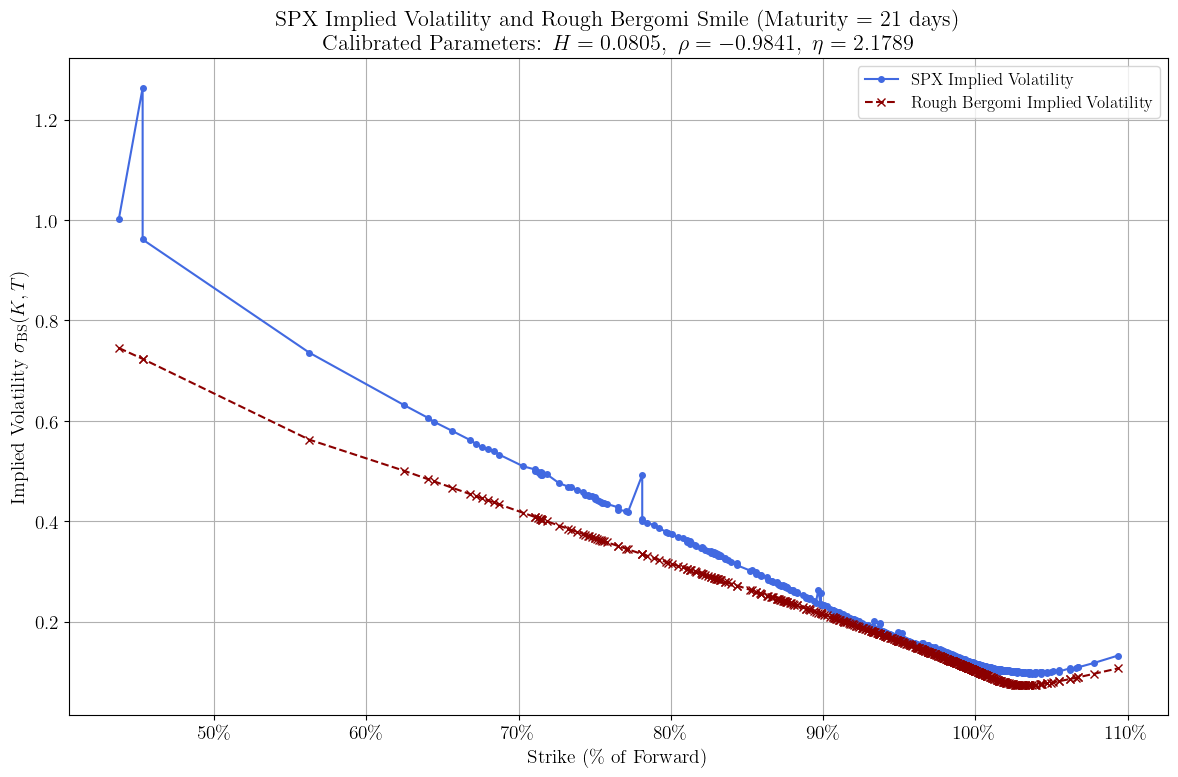

In [5]:
# ==============================================================================
# MAIN EXECUTION BLOCK FOR GRAPHS
# ==============================================================================

if __name__ == '__main__':

    # --- Step 1: Define Core Inputs ---
    options_file_path = 'UnderlyingOptionsEODCalcs_2025-07-25.csv' 
    constant_dividend_yield_to_use = 0.015

    # This step loads the market data and calculates rates/market IVs
    spot_price, quote_date, final_surface_df, r_func, q_func = prepare_full_surface_and_rates(
        options_file_path, 
        constant_dividend_yield=constant_dividend_yield_to_use
    )

    if spot_price is None:
        # Exit if data loading failed
        exit() 
    
    # This step bootstraps the forward variance from the market data
    atm_curve_df = extract_atm_volatility_curve(final_surface_df, spot_price)
    xi_func = create_xi_from_market_atm(atm_curve_df)
  
    # Define the parameters selected from the Differential Evolution log or SLSQP log (decided manually which one is better)
    selected_params = {
        'H': 0.0805, 
        'rho': -0.9841, 
        'eta': 2.1789
    }
    
    print(f"Selected Parameters: H={selected_params['H']}, Rho={selected_params['rho']}, Eta={selected_params['eta']}")

    plot_single_maturity_smile(spot_price, final_surface_df, r_func, q_func, xi_func, selected_params, target_days=21)

--- Reading and processing raw options data... ---
Data processing complete. Found 3386 valid options. S0=6389.52

--- Extracting ATM Volatility Curve from Market Data ---
Extracted 48 ATM points.

--- Creating market-consistent xi_func from ATM Volatilities ---
Market-consistent xi_func created successfully.
Selected Parameters: H=0.0805, Rho=-0.9841, Eta=2.1789

--- Starting Plot Generation for 30-Day Maturity ---
Closest maturity found: 31.0 days (T=0.0849).
Starting high-precision simulation (1000000 paths, 50 steps)...
Simulation complete.
Plot saved as 'Smile_T30_H0.0805_Rho-0.9841_Eta2.1789.png'.


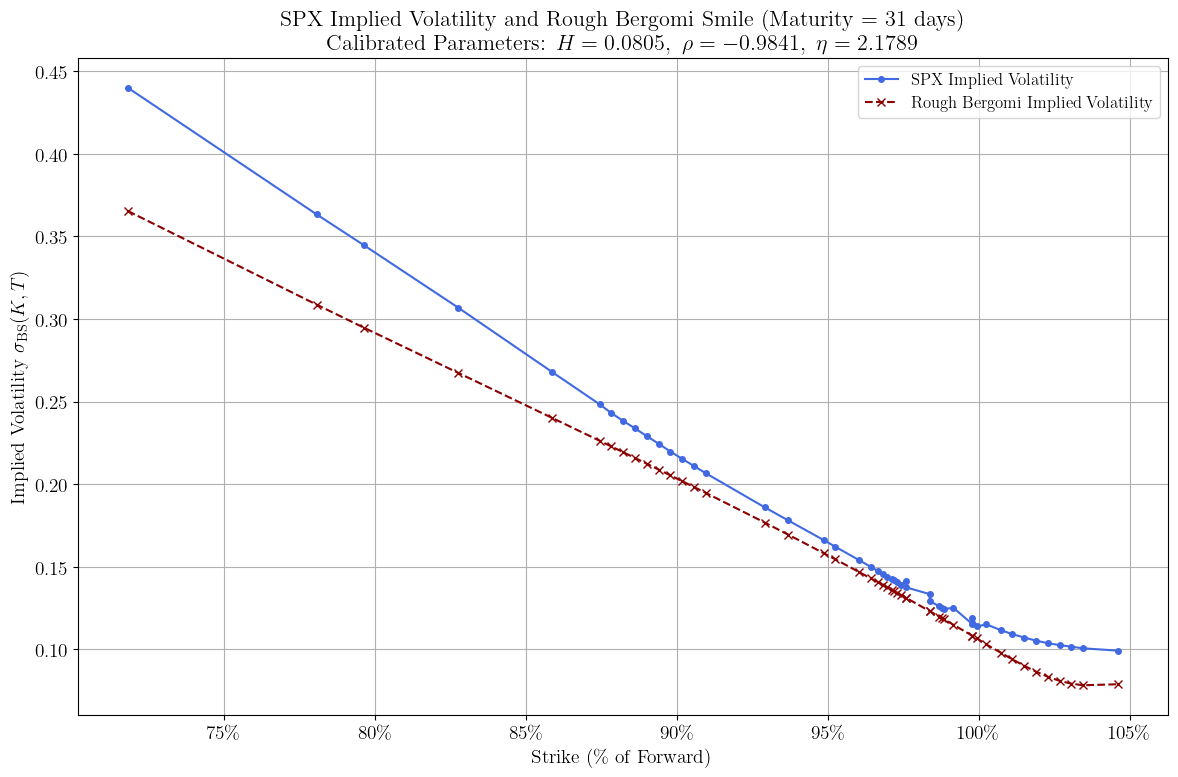

In [6]:
# ==============================================================================
# MAIN EXECUTION BLOCK FOR GRAPHS
# ==============================================================================

if __name__ == '__main__':

    # --- Step 1: Define Core Inputs ---
    options_file_path = 'UnderlyingOptionsEODCalcs_2025-07-25.csv' 
    constant_dividend_yield_to_use = 0.015

    # This step loads the market data and calculates rates/market IVs
    spot_price, quote_date, final_surface_df, r_func, q_func = prepare_full_surface_and_rates(
        options_file_path, 
        constant_dividend_yield=constant_dividend_yield_to_use
    )

    if spot_price is None:
        # Exit if data loading failed
        exit() 
    
    # This step bootstraps the forward variance from the market data
    atm_curve_df = extract_atm_volatility_curve(final_surface_df, spot_price)
    xi_func = create_xi_from_market_atm(atm_curve_df)
  
    # Define the parameters selected from the Differential Evolution log or SLSQP log (decided manually which one is better)
    selected_params = {
        'H': 0.0805, 
        'rho': -0.9841, 
        'eta': 2.1789
    }
    
    print(f"Selected Parameters: H={selected_params['H']}, Rho={selected_params['rho']}, Eta={selected_params['eta']}")

    plot_single_maturity_smile(spot_price, final_surface_df, r_func, q_func, xi_func, selected_params, target_days=30)

--- Reading and processing raw options data... ---
Data processing complete. Found 3386 valid options. S0=6389.52

--- Extracting ATM Volatility Curve from Market Data ---
Extracted 48 ATM points.

--- Creating market-consistent xi_func from ATM Volatilities ---
Market-consistent xi_func created successfully.
Selected Parameters: H=0.0805, Rho=-0.9841, Eta=2.1789

--- Starting Plot Generation for 60-Day Maturity ---
Closest maturity found: 56.0 days (T=0.1534).
Starting high-precision simulation (1000000 paths, 50 steps)...
Simulation complete.
Plot saved as 'Smile_T60_H0.0805_Rho-0.9841_Eta2.1789.png'.


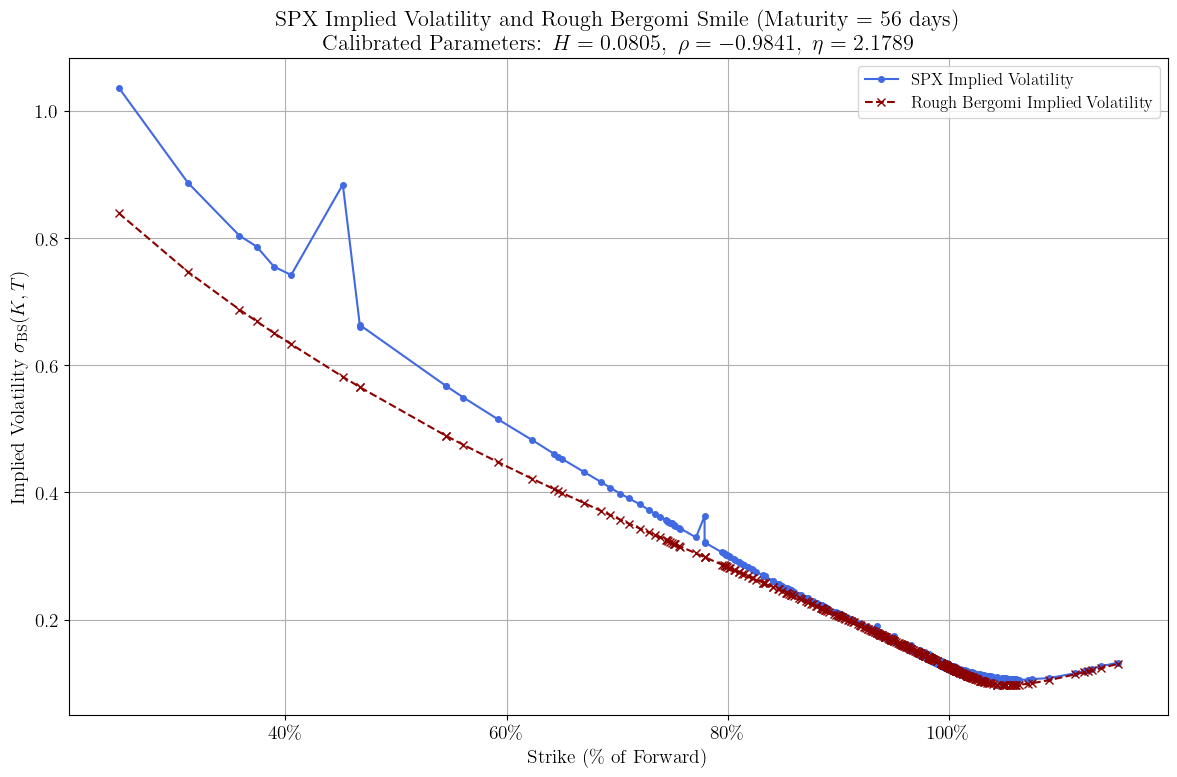

In [7]:
# ==============================================================================
# MAIN EXECUTION BLOCK FOR GRAPHS
# ==============================================================================

if __name__ == '__main__':

    # --- Step 1: Define Core Inputs ---
    options_file_path = 'UnderlyingOptionsEODCalcs_2025-07-25.csv' 
    constant_dividend_yield_to_use = 0.015

    # This step loads the market data and calculates rates/market IVs
    spot_price, quote_date, final_surface_df, r_func, q_func = prepare_full_surface_and_rates(
        options_file_path, 
        constant_dividend_yield=constant_dividend_yield_to_use
    )

    if spot_price is None:
        # Exit if data loading failed
        exit() 
    
    # This step bootstraps the forward variance from the market data
    atm_curve_df = extract_atm_volatility_curve(final_surface_df, spot_price)
    xi_func = create_xi_from_market_atm(atm_curve_df)
  
    # Define the parameters selected from the Differential Evolution log or SLSQP log (decided manually which one is better)
    selected_params = {
        'H': 0.0805, 
        'rho': -0.9841, 
        'eta': 2.1789
    }
    
    print(f"Selected Parameters: H={selected_params['H']}, Rho={selected_params['rho']}, Eta={selected_params['eta']}")

    plot_single_maturity_smile(spot_price, final_surface_df, r_func, q_func, xi_func, selected_params, target_days=60)

--- Reading and processing raw options data... ---
Data processing complete. Found 3386 valid options. S0=6389.52

--- Extracting ATM Volatility Curve from Market Data ---
Extracted 48 ATM points.

--- Creating market-consistent xi_func from ATM Volatilities ---
Market-consistent xi_func created successfully.
Selected Parameters: H=0.0805, Rho=-0.9841, Eta=2.1789

--- Starting Plot Generation for 90-Day Maturity ---
Closest maturity found: 84.0 days (T=0.2301).
Starting high-precision simulation (1000000 paths, 50 steps)...
Simulation complete.
Plot saved as 'Smile_T90_H0.0805_Rho-0.9841_Eta2.1789.png'.


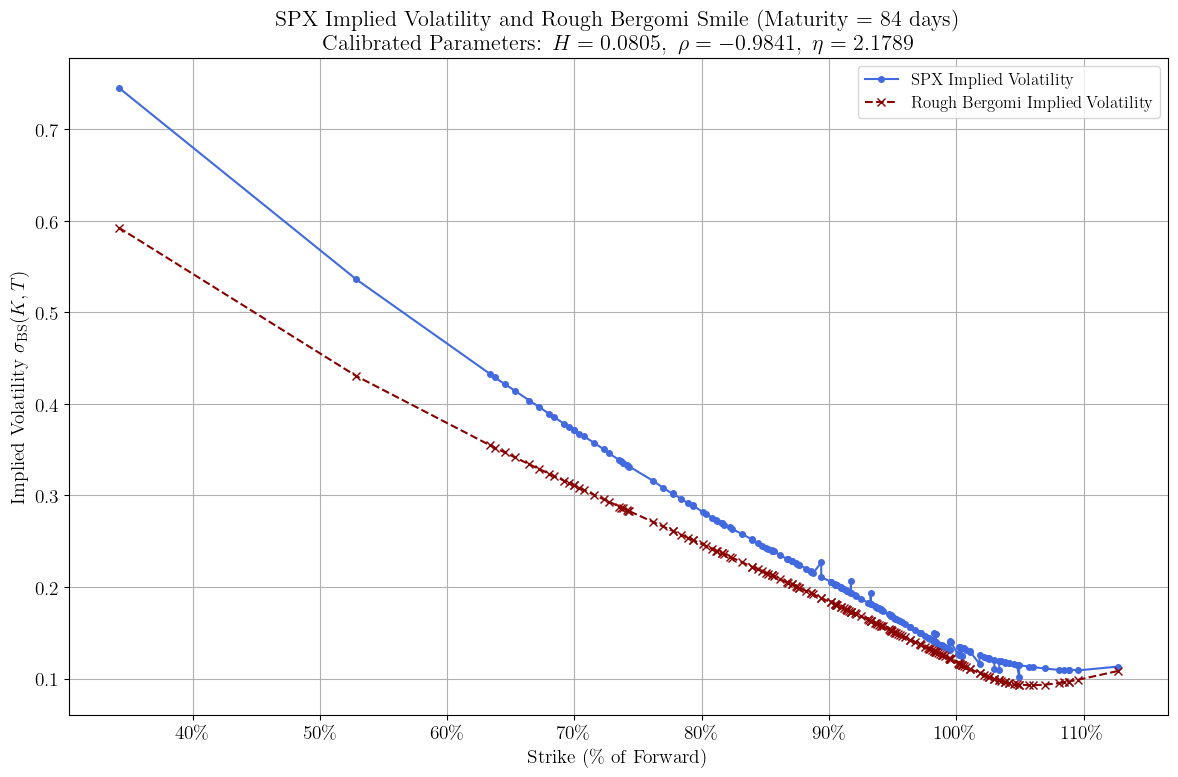

In [8]:
# ==============================================================================
# MAIN EXECUTION BLOCK FOR GRAPHS
# ==============================================================================

if __name__ == '__main__':

    # --- Step 1: Define Core Inputs ---
    options_file_path = 'UnderlyingOptionsEODCalcs_2025-07-25.csv' 
    constant_dividend_yield_to_use = 0.015

    # This step loads the market data and calculates rates/market IVs
    spot_price, quote_date, final_surface_df, r_func, q_func = prepare_full_surface_and_rates(
        options_file_path, 
        constant_dividend_yield=constant_dividend_yield_to_use
    )

    if spot_price is None:
        # Exit if data loading failed
        exit() 
    
    # This step bootstraps the forward variance from the market data
    atm_curve_df = extract_atm_volatility_curve(final_surface_df, spot_price)
    xi_func = create_xi_from_market_atm(atm_curve_df)
  
    # Define the parameters selected from the Differential Evolution log or SLSQP log (decided manually which one is better)
    selected_params = {
        'H': 0.0805, 
        'rho': -0.9841, 
        'eta': 2.1789
    }
    
    print(f"Selected Parameters: H={selected_params['H']}, Rho={selected_params['rho']}, Eta={selected_params['eta']}")

    plot_single_maturity_smile(spot_price, final_surface_df, r_func, q_func, xi_func, selected_params, target_days=90)

--- Reading and processing raw options data... ---
Data processing complete. Found 3386 valid options. S0=6389.52

--- Extracting ATM Volatility Curve from Market Data ---
Extracted 48 ATM points.

--- Creating market-consistent xi_func from ATM Volatilities ---
Market-consistent xi_func created successfully.
Selected Parameters: H=0.0805, Rho=-0.9841, Eta=2.1789

--- Starting Plot Generation for 180-Day Maturity ---
Closest maturity found: 175.0 days (T=0.4795).
Starting high-precision simulation (1000000 paths, 50 steps)...
Simulation complete.
Plot saved as 'Smile_T180_H0.0805_Rho-0.9841_Eta2.1789.png'.


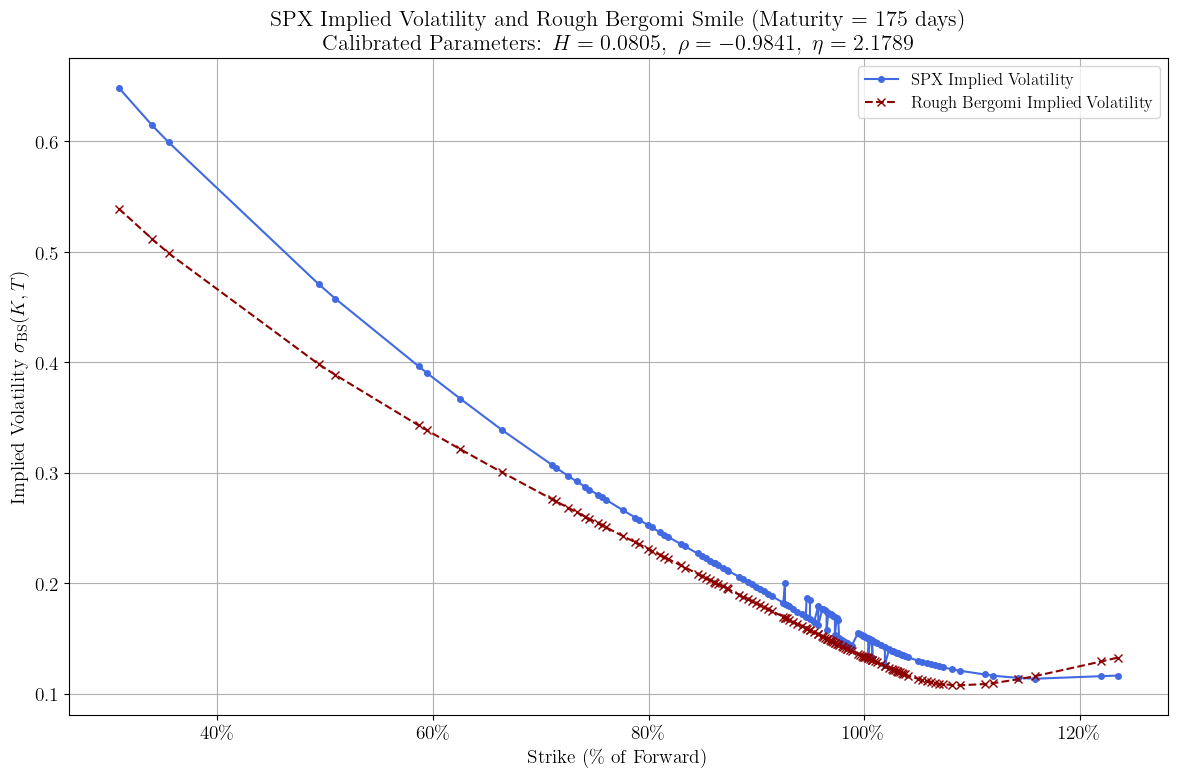

In [9]:
# ==============================================================================
# MAIN EXECUTION BLOCK FOR GRAPHS
# ==============================================================================

if __name__ == '__main__':

    # --- Step 1: Define Core Inputs ---
    options_file_path = 'UnderlyingOptionsEODCalcs_2025-07-25.csv' 
    constant_dividend_yield_to_use = 0.015

    # This step loads the market data and calculates rates/market IVs
    spot_price, quote_date, final_surface_df, r_func, q_func = prepare_full_surface_and_rates(
        options_file_path, 
        constant_dividend_yield=constant_dividend_yield_to_use
    )

    if spot_price is None:
        # Exit if data loading failed
        exit() 
    
    # This step bootstraps the forward variance from the market data
    atm_curve_df = extract_atm_volatility_curve(final_surface_df, spot_price)
    xi_func = create_xi_from_market_atm(atm_curve_df)
  
    # Define the parameters selected from the Differential Evolution log or SLSQP log (decided manually which one is better)
    selected_params = {
        'H': 0.0805, 
        'rho': -0.9841, 
        'eta': 2.1789
    }
    
    print(f"Selected Parameters: H={selected_params['H']}, Rho={selected_params['rho']}, Eta={selected_params['eta']}")

    plot_single_maturity_smile(spot_price, final_surface_df, r_func, q_func, xi_func, selected_params, target_days=180)

--- Reading and processing raw options data... ---
Data processing complete. Found 3386 valid options. S0=6389.52

--- Extracting ATM Volatility Curve from Market Data ---
Extracted 48 ATM points.

--- Creating market-consistent xi_func from ATM Volatilities ---
Market-consistent xi_func created successfully.
Selected Parameters: H=0.0805, Rho=-0.9841, Eta=2.1789

--- Starting Plot Generation for 360-Day Maturity ---
Closest maturity found: 357.0 days (T=0.9781).
Starting high-precision simulation (1000000 paths, 97 steps)...
Simulation complete.
Plot saved as 'Smile_T360_H0.0805_Rho-0.9841_Eta2.1789.png'.


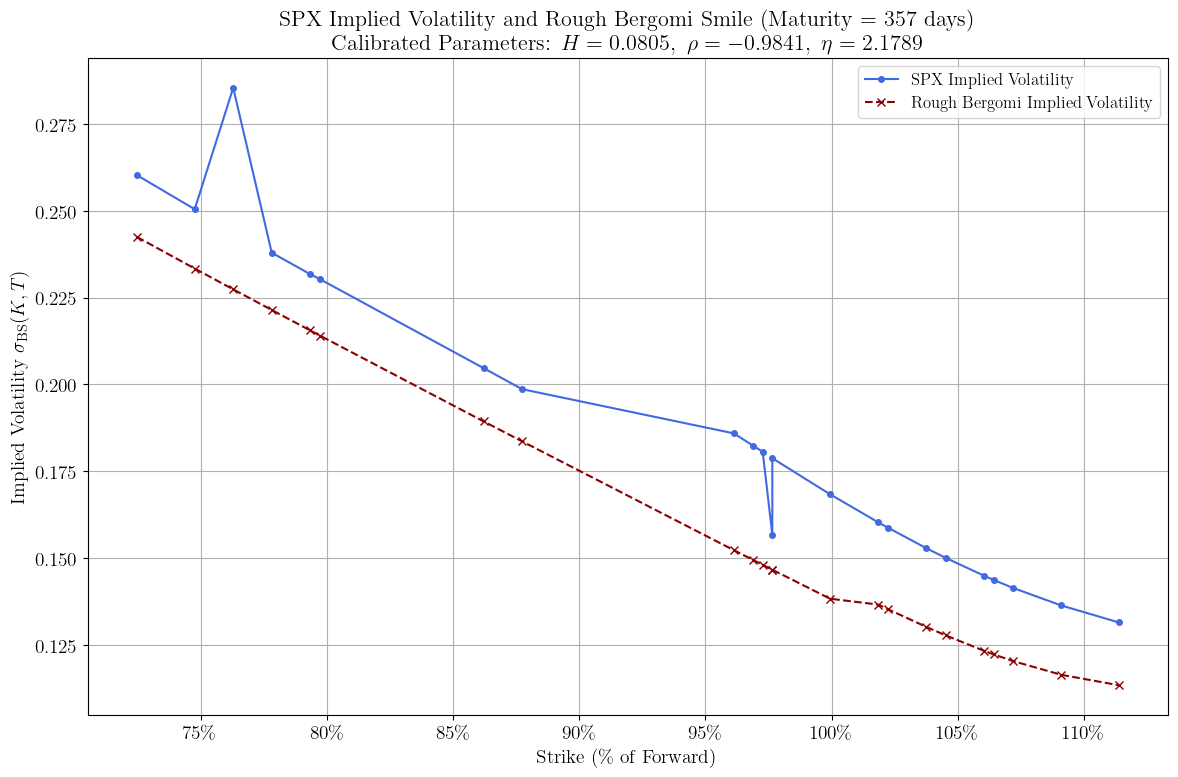

In [10]:
# ==============================================================================
# MAIN EXECUTION BLOCK FOR GRAPHS
# ==============================================================================

if __name__ == '__main__':

    # --- Step 1: Define Core Inputs ---
    options_file_path = 'UnderlyingOptionsEODCalcs_2025-07-25.csv' 
    constant_dividend_yield_to_use = 0.015

    # This step loads the market data and calculates rates/market IVs
    spot_price, quote_date, final_surface_df, r_func, q_func = prepare_full_surface_and_rates(
        options_file_path, 
        constant_dividend_yield=constant_dividend_yield_to_use
    )

    if spot_price is None:
        # Exit if data loading failed
        exit() 
    
    # This step bootstraps the forward variance from the market data
    atm_curve_df = extract_atm_volatility_curve(final_surface_df, spot_price)
    xi_func = create_xi_from_market_atm(atm_curve_df)
  
    # Define the parameters selected from the Differential Evolution log or SLSQP log (decided manually which one is better)
    selected_params = {
        'H': 0.0805, 
        'rho': -0.9841, 
        'eta': 2.1789
    }
    
    print(f"Selected Parameters: H={selected_params['H']}, Rho={selected_params['rho']}, Eta={selected_params['eta']}")

    plot_single_maturity_smile(spot_price, final_surface_df, r_func, q_func, xi_func, selected_params, target_days=360)